<a href="https://colab.research.google.com/github/yuleidner/DAV-6150/blob/main/M7_assn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#colab current default is sklearn .022 current it v1 updating
!pip install -U scikit-learn
# Installing yellow brick for their fun visualizers
!pip install -U yellowbrick
# updating mlextend 
!pip install -U mlxtend

     |████████████████████████████████| 23.2 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 271 kB 5.4 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1
     |████████████████████████████████| 1.3 MB 5.6 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


# Data Science: Module 7
## Practical Challenge: Binary Logistic Regression
### Jacob Goodman & Alan Leidner
#### Oct 31, 2021
Assignment: https://yu.instructure.com/courses/50398/assignments/191956

# Introduction

This notebook will apply the full data science project lifecycle to the implementation and evaluation of a series of binary logistic regression models that predict whether or not a given existing customer is likely to purchase an additional insurance product from the company. 

After constructing and evaluating our models, we will identify our preferred model and apply it to a testing subset to assess its performance.

The data set we will be using is sourced from a Kaggle contribution:  https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv

The data set is comprised of more than 14,000 observations of 1 response/dependent variable (which indicates whether or not the new insurance product was purchased) and 14 explanatory/independent variables. The insurance company gathered data about customers to whom they offered the new product. We are given information about whether they did or did not sign up for the new product, together with some customer information and information about their buying behavior of two other products. 

# Import Dependencies

In [ ]:
#colab current default is sklearn .022 current it v1 updating
#!pip install -U scikit-learn should only need to be run once or at max once persession
#import packages for data frames 
import numpy as np
import pandas as pd

#import pyplot and seaborn for graph creating
import matplotlib.pyplot as plt
import seaborn as sns 

#import for modeling & model evaluation
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from patsy import dmatrices
from yellowbrick.model_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploratory Data Analysis <a id='1'></a>
The dataset was loaded into the DAV 6150 Github Repository here: https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M7/M7_Data.csv. This notebook will now load the csv into a Pandas dataframe for analysis.

In [ ]:
# read a set of sample data from github. It contains information related to cars and insurance
filename = "https://raw.githubusercontent.com/yuleidner/DAV-6150/main/M7/M7_Data.csv"
df = pd.read_csv(filename)
pd.set_option('display.max_columns', None)# expands df to display all columns
df.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


## Attribute Information
0. TARGET: Indicator of buying the new product (0 = no, 1= yes)
1. loyalty: Loyalty level, from low to high (0 to 3), 99 = unclassified
2. ID: Unique customer identifier
3. age: Age in years
4. city: Unique code per city
5. LOR: Length of relationship in years
6. prod_A: Bought Product A (0=no, 1=yes)
7. type_A: Type of product A
8. prod_B: Bought Product B (0=no, 1=yes)
9. type_B: Type of product B
10. turnover_A: Amount of money spent on Product A
11. turnover_B: Amount of money spent on Product B
12. contract: Type of contract
13. age_p: Age of partner in years
14. lor_m: Length of relationship in months


## Data Validation

In [ ]:
## a few methods will now be called to view summaries of this dataframe
df.shape

(14016, 15)

In [ ]:
#check to validate data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TARGET      14016 non-null  object 
 1   loyalty     14016 non-null  int64  
 2   ID          14016 non-null  int64  
 3   age         14016 non-null  int64  
 4   city        14016 non-null  int64  
 5   LOR         14016 non-null  int64  
 6   prod_A      14016 non-null  int64  
 7   type_A      14016 non-null  int64  
 8   type_B      14016 non-null  int64  
 9   prod_B      14016 non-null  int64  
 10  turnover_A  14016 non-null  float64
 11  turnover_B  14016 non-null  float64
 12  contract    14016 non-null  int64  
 13  age_P       14016 non-null  int64  
 14  lor_M       14016 non-null  int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 1.6+ MB


We will need to transform our target from a Y/N object into a 1/0 int.

In [ ]:
df['TARGET'] = df['TARGET'].map({'Y':1 ,'N':0}).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TARGET      14016 non-null  int64  
 1   loyalty     14016 non-null  int64  
 2   ID          14016 non-null  int64  
 3   age         14016 non-null  int64  
 4   city        14016 non-null  int64  
 5   LOR         14016 non-null  int64  
 6   prod_A      14016 non-null  int64  
 7   type_A      14016 non-null  int64  
 8   type_B      14016 non-null  int64  
 9   prod_B      14016 non-null  int64  
 10  turnover_A  14016 non-null  float64
 11  turnover_B  14016 non-null  float64
 12  contract    14016 non-null  int64  
 13  age_P       14016 non-null  int64  
 14  lor_M       14016 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 1.6 MB


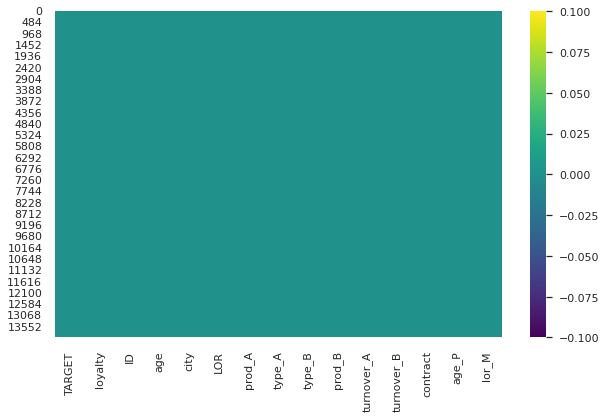

In [ ]:
#null visualization sanity check
sns.set(rc={'figure.figsize':(10,6)})
sns.heatmap(df.isnull(), cmap='viridis');

## Univariate Analysis

### Custom Function
We find ourselves turning to the same methods and visualizations for univariate analysis. The following function will be utilized to standardize our EDA and simplify code.

In [ ]:
def distbox (i,df , type = 'numeric',normalize=True):
  """ 
  This function is designed to provide distribution statics and visualizations of dataframe columns
  it takes in a column number and dataframe and can return:
   numerical output -
            1. the skewness of the column
            2. the kurtosis or spread
            3. the descriptive statisticts from .describe()
            4. a histogram and boxplot
            
  OR categorical -        
            1. countplot
            2. values counts (either count or as percentages)
  """
  #best practice import dependencies in functions
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import warnings 
  warnings.filterwarnings("ignore", category=FutureWarning)
  c = df.iloc[:,i]
  plt.figure(figsize=(8,4))
  if type =='numeric':
    plt.subplot(1,2,1);#Histogram location
    sns.distplot(c);#calls a histogram
    plt.title(df.columns[i]);#adds title
    plt.subplot(1,2,2);#Boxplot location
    sns.boxplot(c);#calls a box and whisket plot
    plt.title(df.columns[i]);#adds title
    print("Skewness: %f" %c.skew()) #Adds Skew value
    # If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
    # If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
    # If the skewness is less than -1 or greater than 1, the data are highly skewed
    print("Kurtosis: %f" %c.kurt(skipna = True)) #Adds Kurtosis value (tail-ness)
    # While kurtosis determines the heaviness of the distribution tails.
    # Kurtosis > 3 thin and not spread
    # Kurtosis <3 moderate spread
    print(c.describe()) #Adds summary statistics of the variable


  elif type == 'categorical':
    sns.countplot(c)
    plt.title(df.columns[i]);#adds title
    print(c.value_counts(normalize=normalize))

  print("Nullcount: %f" %c.isnull().sum().sum())
  plt.show() # this will load image to console before executing next line of code

### TARGET

0    0.570776
1    0.429224
Name: TARGET, dtype: float64
Nullcount: 0.000000


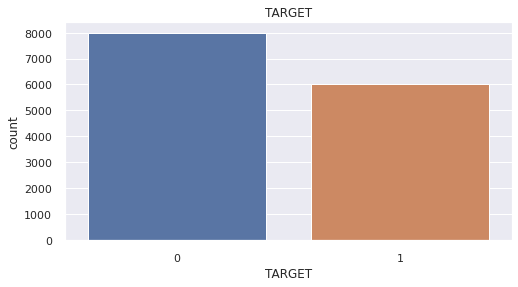

In [ ]:
distbox(0,df,type='categorical')

In [ ]:
count_0 = len(df[df['TARGET']==0])
count_1 = len(df[df['TARGET']==1])
pct_of_0 = count_0/(count_0+count_1)
print("percentage of no additional purchase is", pct_of_0*100)
pct_of_1 = count_1/(count_0+count_1)
print("percentage of subscription", pct_of_1*100)

percentage of no addtional purchase is 57.077625570776256
percentage of subscription 42.922374429223744


These classes are relatively balanced.

### loyalty

99    0.498430
3     0.218964
1     0.176941
2     0.101670
0     0.003995
Name: loyalty, dtype: float64
Nullcount: 0.000000


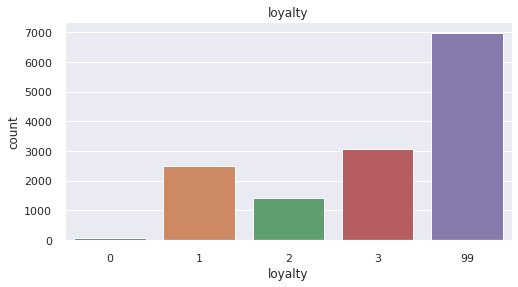

In [ ]:
distbox(1,df,type = 'categorical') 

**conclusions**

0 level loyalty is very sparse with only .39% of records and uncategorized 99 is over represented. According to https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv 99 represents unclassified data. 

We will transform this feature to preserve the ordinal nature. We will add 1 to every value, and then convert the uncategorized to 0. Although uncategorized is not lower than "0" we want to transform this feature while preserving ordinality.

### ID

Skewness: 1.214266
Kurtosis: 0.013023
count     14016.000000
mean      37672.440068
std       44855.639209
min           1.000000
25%        6741.500000
50%       13514.500000
75%       62738.000000
max      151811.000000
Name: ID, dtype: float64
Nullcount: 0.000000


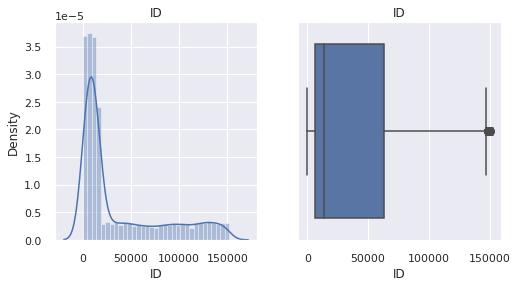

66853     2
147678    2
21091     2
107064    2
139877    2
         ..
5186      1
14042     1
11993     1
9944      1
16384     1
Name: ID, Length: 11008, dtype: int64
1.2732558139534884


In [ ]:
distbox(2,df )
print(df.iloc[:,2].value_counts())
print(df.iloc[:,2].value_counts().mean())

Some user IDs appear twice but most appear only 1 once. This column has an extreme level of cardinality. Perhaps useful features could be extracted from users occurring multiple times or they could represent duplicates that need to be dropped.
 

In [ ]:
#examining one of the extra columns 
df[df['ID']==147678]

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
2919,1,99,147678,28,2,1,1,3,3,1,448.420392,218.86623,2,28,15
13927,1,99,147678,28,2,1,1,3,3,1,448.420392,218.86623,2,28,15


**conclusions** 
This looks like a duplicate record that we will remove. This column is an index and should not be included in models, or other duplicate entries.

### age   
the age customer.


Skewness: 1.171141
Kurtosis: 1.368278
count    14016.000000
mean        35.882920
std         12.974634
min          5.000000
25%         25.000000
50%         33.000000
75%         43.000000
max        102.000000
Name: age, dtype: float64
Nullcount: 0.000000


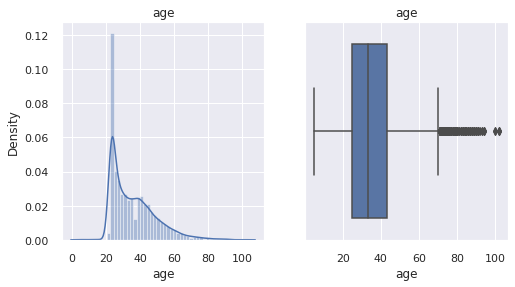

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
2976,1,99,150547,102,2,1,0,0,0,0,436.054680,258.432573,2,102,15
3253,0,99,513,100,2,0,0,0,0,0,347.703304,209.913216,2,100,3
5454,0,3,5094,102,2,1,0,0,3,1,367.491079,3210.235891,2,102,15
7910,0,99,10232,100,2,0,0,0,0,0,379.502621,235.877083,2,100,3
13984,1,99,150547,102,2,1,0,0,0,0,436.054680,258.432573,2,102,15


In [ ]:
distbox(3,df)
display(df[df['age']>95])

**conclusions**   
Age in this data set is right skewed. While there are a few large values none that are outside the realm of possibility. We will standardize and normalize.

### city  
id for each city 

2      0.978881
1      0.001998
0      0.001855
8      0.001498
9      0.001427
         ...   
127    0.000071
131    0.000071
115    0.000071
107    0.000071
187    0.000071
Name: city, Length: 65, dtype: float64
Nullcount: 0.000000


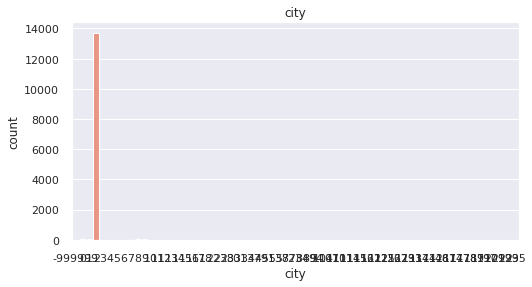

In [ ]:
distbox(4,df,type= 'categorical') 

In [ ]:
df.city[df.iloc[:,4]<0].unique()

array([-999999])

In [ ]:
df.city[df.iloc[:,4]<0].count()

10

**conclusions** 

97% of the city values are in a single class out of 65 distinct values. We think the negative value is probably a null stand in.
   
To handle this feature we will convert it to an indicator column "not in city_2" effectively turning this into an indicator column.

### LOR   
Length of relationship in years

Skewness: 1.108936
Kurtosis: 1.175228
count    14016.000000
mean         0.926299
std          0.965212
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: LOR, dtype: float64
Nullcount: 0.000000


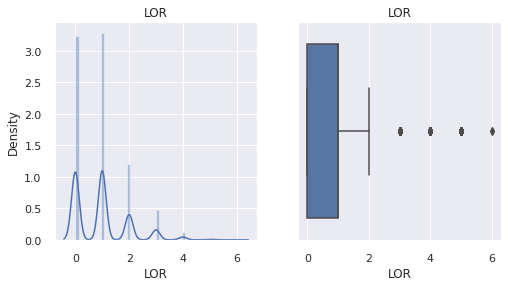

In [ ]:
distbox(5,df)

**conclusion** 

The length of relationship column is right skewed with a few outliers but no signs of unrealistic values. We will standardize and normalize.

### prod_A
customer bought product A.  
1 = yes 0 = no

1    7482
0    6534
Name: prod_A, dtype: int64
Nullcount: 0.000000


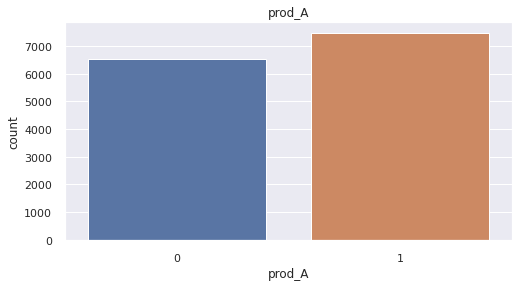

In [ ]:
distbox(6,df,type='categorical',normalize=False)

**conclusion** 

The classes are fairly evenly distributed. They seem to have the opposite proportion to our response variable. No data preparation work should be needed. 

### type_A
The type of product A is

3    7452
0    6534
6      30
Name: type_A, dtype: int64
Nullcount: 0.000000


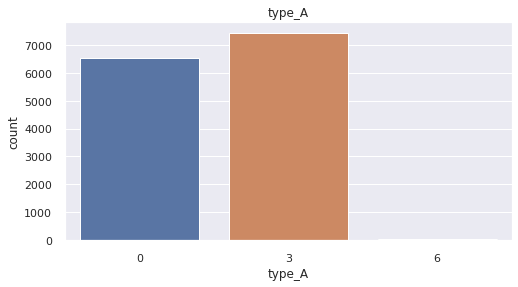

In [ ]:
distbox(7,df,type='categorical',normalize=False)

In [ ]:
# checking to see type_A is always = 0 when Prod_a is 
sum(df.iloc[:,7]==df.iloc[:,6])

6534

**Conclusion** 

The type_A feature has a very sparse class and 0 values are = to zero values in prod_A. 

If dummied only 1 0 column should be retained. 
The sparse class might be left due to a limited number of classes and included in the stratification term of test train split.


### type_B
type of product B

3    0.561787
0    0.400542
6    0.035174
9    0.002497
Name: type_B, dtype: float64
Nullcount: 0.000000


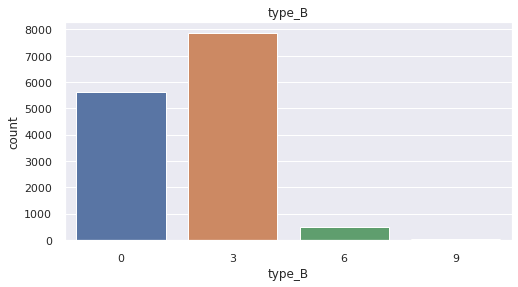

In [ ]:
distbox(8,df,type='categorical')

**conclusion** 

The type_B feature has two sparse classes. The sparse classes might be left due to the limited number of classes and included in the  stratification term of test train split.

### prod_B

1    8402
0    5614
Name: prod_B, dtype: int64
Nullcount: 0.000000


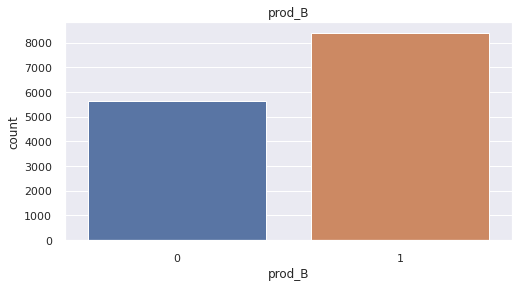

In [ ]:
distbox(9,df,type='categorical',normalize=False)

In [ ]:
# validate zero condition is present here as well between prod_b and type_B
sum(df.iloc[:,8]==df.iloc[:,9])

5614

**conclusion**

The prod_B feature is relatively evenly distributed, but 0 values are equal to the zero values in type_B. If dummied only 1 0 column should be retained. 

### turnover_A  
 Amount of money spent on Product A

Skewness: 21.220275
Kurtosis: 900.222515
count    14016.000000
mean       379.161320
std         92.612207
min        300.095909
25%        334.919412
50%        367.891493
75%        399.744923
max       5568.784139
Name: turnover_A, dtype: float64
Nullcount: 0.000000


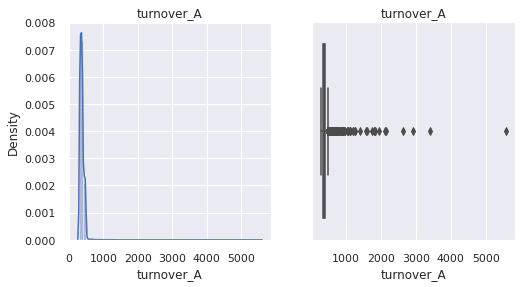

In [ ]:
distbox(10,df)

In [ ]:
# exploring outliers
df[df.iloc[:,10]>2000]

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
4998,0,99,4129,43,2,1,1,3,3,1,2630.436929,2513.647649,2,43,15
6116,0,3,6523,51,2,1,1,3,3,1,3417.423272,3245.107895,2,51,15
7857,0,1,10110,57,2,2,1,3,3,1,5568.784139,5442.041434,2,57,27
8154,0,2,10768,45,2,1,1,3,3,1,2106.224034,2030.227497,2,45,15
8710,0,2,11919,49,2,1,1,3,3,1,2149.771342,2020.890297,2,49,15
9026,0,99,12616,71,2,1,1,3,3,1,2921.246639,2770.526018,2,71,15


**conclusion**

Outliers severley skew this feature, but may contain variance. We will normalize and standardize.

### turnover_B
 Amount of money spent on Product B

Skewness: 8.132714
Kurtosis: 93.168773
count    14016.000000
mean       328.628207
std        475.616525
min        191.962852
25%        219.406925
50%        237.656757
75%        264.131538
max      12249.084770
Name: turnover_B, dtype: float64
Nullcount: 0.000000


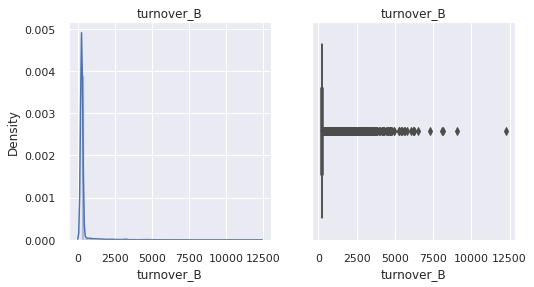

In [ ]:
distbox(11,df)

**Conclusion**

Outliers severley skew this  feature, but may contain variance. We will normalize and standardize.

### contract
type of contract

2    1.0
Name: contract, dtype: float64
Nullcount: 0.000000


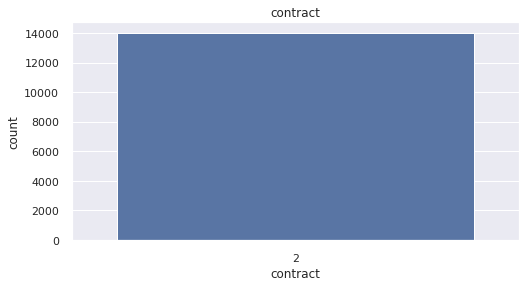

In [ ]:
distbox(12,df,type = 'categorical')

**conclusion** 

This column has no variance and will be dropped.

### age_P
Age of partner in years

Skewness: 1.171141
Kurtosis: 1.368278
count    14016.000000
mean        35.882920
std         12.974634
min          5.000000
25%         25.000000
50%         33.000000
75%         43.000000
max        102.000000
Name: age_P, dtype: float64
Nullcount: 0.000000


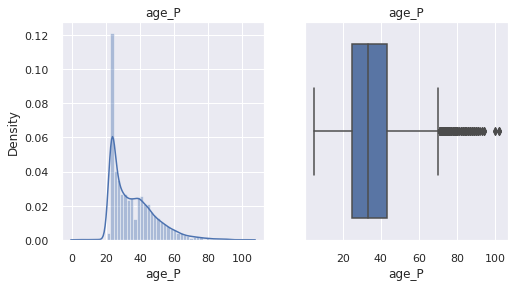

In [ ]:
distbox(13,df)

This column appears to have a very similar distribution as age, right skewed without unreasonable outliers. We will check for independence in the next section.

In [ ]:
#sanity check
df[['age','age_P']].head()

,age,age_P
0,66,66
1,45,45
2,42,42
3,31,31
4,62,62


In [ ]:
df[['age','age_P']].corr()

,age,age_P
age,1.0,1.0
age_P,1.0,1.0


**conclusion** 

age_P is a duplicate column and will be dropped.

### lor_M
Length of relationship in months

Skewness: 1.108936
Kurtosis: 1.175228
count    14016.000000
mean        14.115582
std         11.582550
min          3.000000
25%          3.000000
50%         15.000000
75%         15.000000
max         75.000000
Name: lor_M, dtype: float64
Nullcount: 0.000000


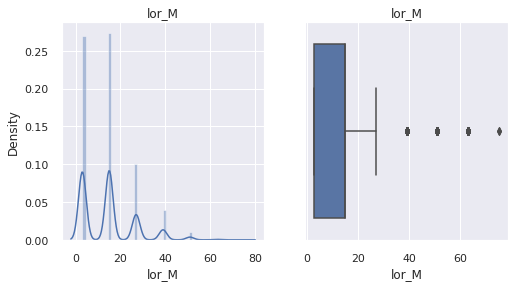

In [ ]:
distbox(14,df)

**conclusion** 

This column has the same distribution as LOR, right skewed without unreasonable outliers. It is dependant which we will verify in the multivariate analysis section. We will likely drop LOR as it contains the same information but on a scale of 12 months, where lor_M is on a 3 month scale, allowing for added granularity.

actions:
* drop either lor_M or LOR
* standardize and normalize if we retain the feature

## Multivariate Analysis

### Quantitative Independence

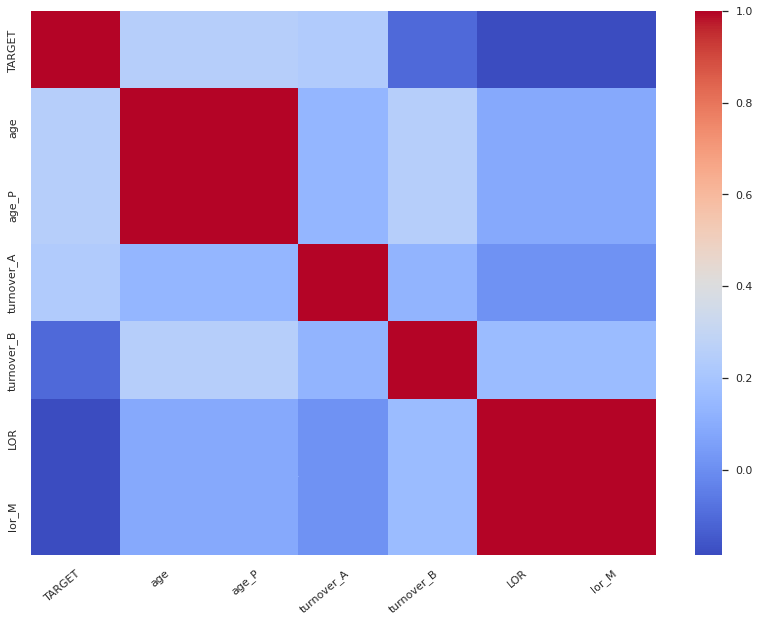

In [ ]:
#Correlation analysis for columns which are not categorical
plt.figure(figsize=(14,10))
sns.heatmap(df[['TARGET','age','age_P','turnover_A','turnover_B','LOR','lor_M']].corr(),cmap='coolwarm',annot=False);
plt.xticks(rotation=40 , rotation_mode='anchor',ha="right");

This reconfirms our decision to drop age_P and LOR

In [ ]:
df.groupby('TARGET').mean()

,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
TARGET,,,,,,,,,,,,,,
0,39.791625,8366.446750,33.027125,-747.257125,1.081375,0.673000,2.025000,2.411625,0.74475,360.368141,371.263176,2.0,33.027125,15.976500
1,64.464428,76643.175864,39.680519,-662.669548,0.720080,0.348737,1.053191,1.263630,0.40625,404.152250,271.932769,2.0,39.680519,11.640957


loyalty, age, prod_A, type_A, type_B, turnover_A, and turnover_B seem like they will contain a good amount of variance to predict our response variable.

### Categorical Independence

Checking for independence of categorical/ordinal data.

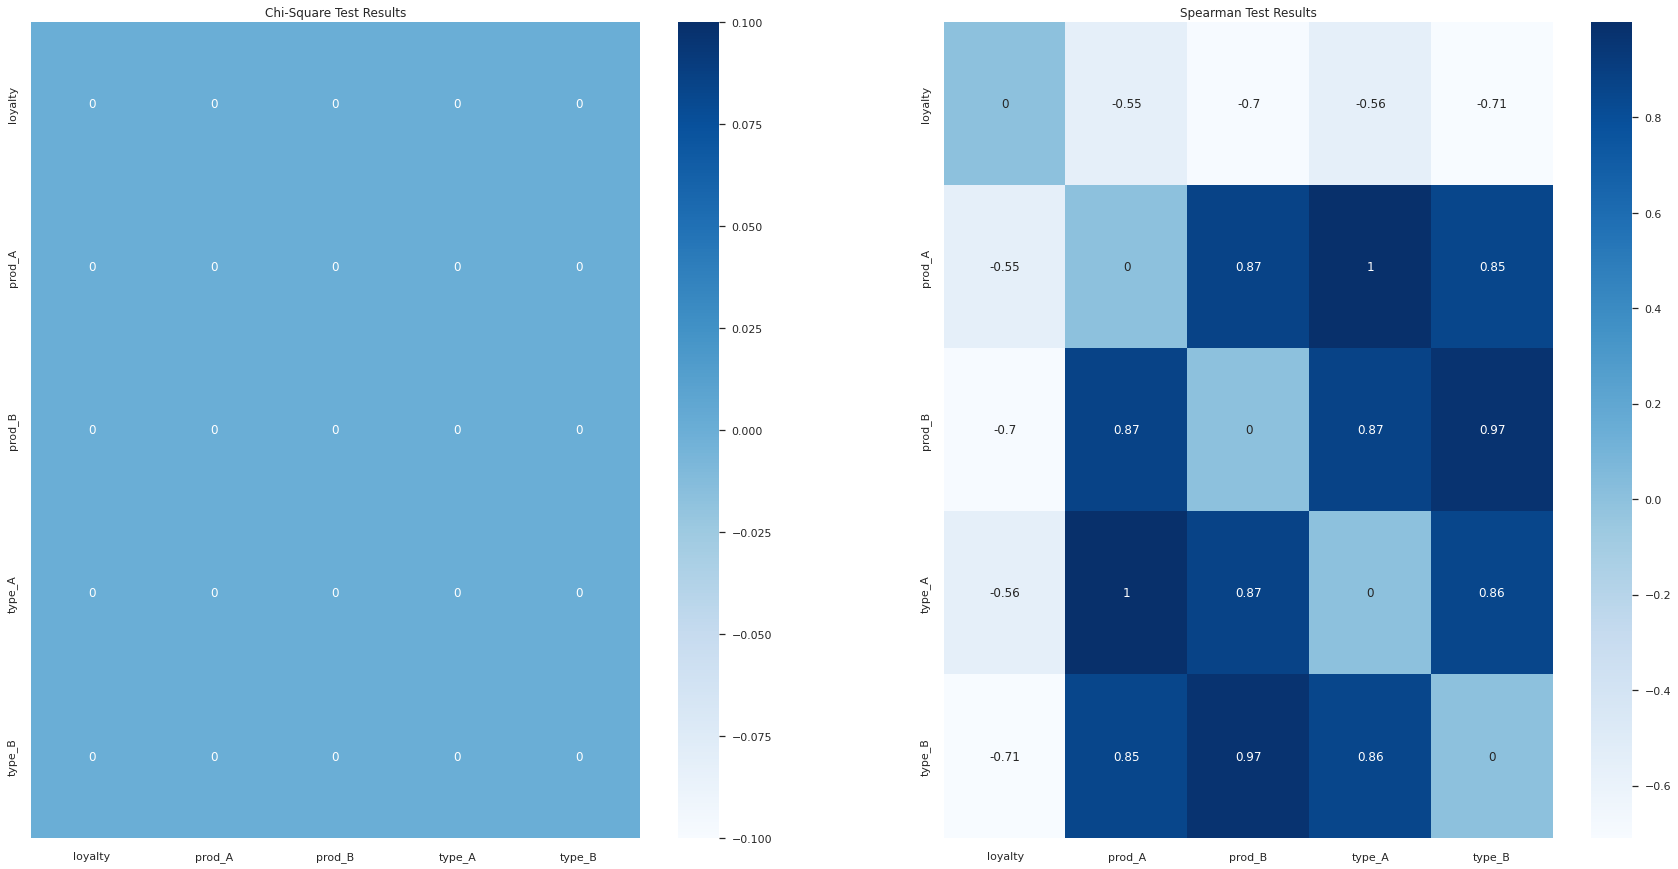

In [ ]:
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
cat_columns = ['loyalty', 'prod_A','prod_B', 'type_A', 'type_B']#not including city at this stage because the functions do not like negative numbers

chi_ps =[]
spearman = []
for cat in cat_columns:
  intermediate_P = []
  intermediat_spear = []
  for second_cat in cat_columns:
    if cat == second_cat:
      intermediate_P.append(0)
      intermediat_spear.append(0)
      continue
    chi = chi2(df[cat].values.reshape(-1, 1),df[second_cat].values.reshape(-1, 1))
    intermediate_P.append(chi[1][0])
    spear = spearmanr(df[cat].values.reshape(-1, 1),df[second_cat].values.reshape(-1, 1))
    intermediat_spear.append(spear[0])
  chi_ps.append(intermediate_P)
  spearman.append(intermediat_spear)


df_pvalues = pd.DataFrame(data= chi_ps,index=cat_columns,columns=cat_columns)
df_spearman = pd.DataFrame(data= spearman,index=cat_columns,columns=cat_columns)
#print(intermediat_spear)
#df_pvalues
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
sns.heatmap(df_pvalues, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.subplot(1,2,2)
sns.heatmap(df_spearman, annot=True, cmap='Blues')
plt.title('Spearman Test Results')
plt.show()

**conclusion**  
$\tilde{\chi}^2$ - our columns pairs  have a P-value of less than .05 from the test. We primarily accept the alternative hypothesis of the $\tilde{\chi}^2$ that these columns are not independent. 

Spearman r - confirms they are not independent, which is not ideal for logistic regressions.

# Data Preparation

LIST OF THINGS TO CHANGE

* create df_prep to preserve original data
* drop duplicate rows from ID 
* drop columns 
  * ID
  * contract
  * LOR
  * age_P
* Dummy Data
  * city change to indicator column not in city_2 
  * Modify loyalty to preserve cardinality and ordinality
* standardize and normalize
  * turnover_A
  * turnover_B
  * age
  * lor_M

note: we did not transform type_A or type_B, as we decide to remove these features during independence testing.

### Create df_prep

In [ ]:
df_prep = df.copy()

### Drop Duplicate Rows

In [ ]:
#sanity check part 1
df_prep.duplicated().sum()

3008

In [ ]:
df_prep = df_prep.drop_duplicates().copy()
df_prep.duplicated().sum()#sanity check part 2

0

### Drop Columns

In [ ]:
df_prep.drop(columns=["ID", "age_P", "contract", 'LOR'], inplace=True)

### Categorical Updates


#### city

In [ ]:
#create city 2 indicator
df_prep['city_2'] = (df_prep['city'] == 2).astype(int);

In [ ]:
#sanity check to see if city = 2 has created value =1 in city_2 dummy column
df_prep[['city','city_2']].head(2) 

,city,city_2
0,2,1
1,2,1


In [ ]:
#sanity check to see if city != 2 has created value = 0 in city_2 dummy column
df_prep[['city','city_2']].loc[df_prep['city'] != 2].head(2)

,city,city_2
56,5,0
236,4,0


In [ ]:
#drop city column
df_prep.drop(columns=['city'], inplace=True)

#### loyalty



In [ ]:
#double check loyalty values
df_prep['loyalty'].head()

0    99
1     1
2     1
3    99
4    99
Name: loyalty, dtype: int64

In [ ]:
#add 1 to every value, preparing to "shuffle" the 99 value to the newly emptied 0 value
df_prep['loyalty'] = df_prep['loyalty']+1 
df_prep['loyalty'].head()

0    100
1      2
2      2
3    100
4    100
Name: loyalty, dtype: int64

In [ ]:
#replace all 100 values with 0
df_prep['loyalty'].replace(100,0,inplace=True)
df_prep['loyalty'].head()

0    0
1    2
2    2
3    0
4    0
Name: loyalty, dtype: int64

In [ ]:
#add indicator column for uncategorized loyalty
df_prep['loyal_uncat'] =  (df_prep['loyalty'] == 0).astype(int)

### Normalize & Standardize

In [ ]:
#turnover_A turnover_B
from sklearn.preprocessing import power_transform as pt 

columns = ['turnover_A', 'turnover_B','age','lor_M']

for column in columns:#iterate over identified columns
  a = df_prep[[column]]
  df_prep[column] = pt(a,method='box-cox')

df_prep[columns].head()#sanity check

,turnover_A,turnover_B,age,lor_M
0,-0.706074,0.687482,1.884014,-1.284430
1,0.728694,1.039941,0.963596,1.627726
2,-0.445272,2.436374,0.780456,1.084097
3,1.514769,0.145817,-0.096020,-1.284430
4,0.546396,1.071100,1.744273,-1.284430


# Data Review
We will now review our data preparation, to check to see that we have improved our data set. We already know that we removed duplicate rows and columns. Now we will check to make sure we have removed all null values, check to see if the univariate analyses have improved, and review our multivariate analyses.

In [ ]:
#first we will load our transformed dataset to review it as a whole, and then compare it to the original
df_prep.head()

,TARGET,loyalty,age,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,lor_M,city_2,loyal_uncat
0,1,0,1.884014,0,0,0,0,-0.706074,0.687482,-1.284430,1,1
1,1,2,0.963596,1,3,3,1,0.728694,1.039941,1.627726,1,0
2,1,2,0.780456,1,3,6,1,-0.445272,2.436374,1.084097,1,0
3,1,0,-0.096020,0,0,0,0,1.514769,0.145817,-1.284430,1,1
4,1,0,1.744273,0,0,0,0,0.546396,1.071100,-1.284430,1,1


In [ ]:
df.shape

(14016, 15)

In [ ]:
df_prep.shape

(11008, 12)

We started with 15 features and reduced that number to 12, some of which are indicator variables. We also removed ~3000 duplicate values.

### Univariate Review

#### loyalty

0    0.458576
4    0.245367
2    0.183412
3    0.107558
1    0.005087
Name: loyalty, dtype: float64
Nullcount: 0.000000


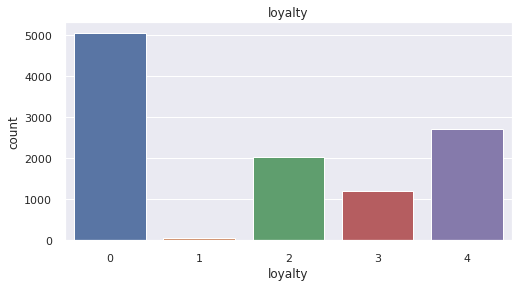

In [ ]:
distbox(1,df_prep,type = 'categorical')#????? why didnt we change

We are hoping this "rearranged" data improves our model. At the very least the "99" will no longer have an outsized impact on the model.

#### age

Skewness: -0.071257
Kurtosis: 2.841234
count    1.100800e+04
mean    -7.081908e-16
std      1.000045e+00
min     -8.780758e+00
25%     -9.324884e-01
50%     -9.601955e-02
75%      7.804561e-01
max      2.756279e+00
Name: age, dtype: float64
Nullcount: 0.000000


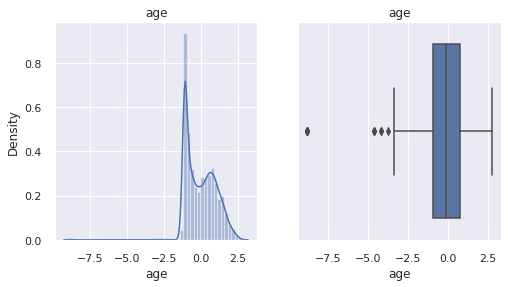

In [ ]:
distbox(2,df_prep)

We have increased the kurtosis, but decreased the skew. We believe this tradeoff is worthwhile as models tend to use standardized datasets better. If we have time, we may attempt other transformations on this feature (or even use an untransformed feature) to see if the alternatives increase model performance.

#### turnover_A

Skewness: 0.055569
Kurtosis: -0.484694
count    1.100800e+04
mean    -2.292991e-09
std      1.000045e+00
min     -1.997145e+00
25%     -7.485809e-01
50%      6.961195e-02
75%      6.736942e-01
max      3.262091e+00
Name: turnover_A, dtype: float64
Nullcount: 0.000000


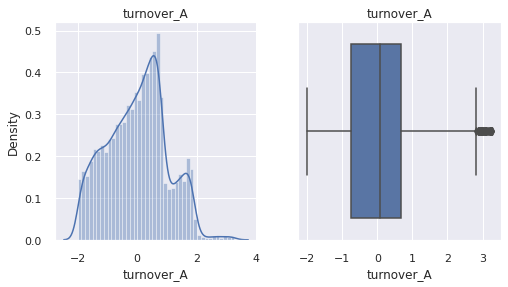

In [ ]:
distbox(7,df_prep)

Using metrics of skew and kurtosis, this feature is much improved.

#### turnover_B

Skewness: 0.733173
Kurtosis: 0.271479
count    1.100800e+04
mean    -1.124334e-09
std      1.000045e+00
min     -2.219340e+00
25%     -7.127797e-01
50%     -7.866306e-02
75%      4.461401e-01
max      2.455805e+00
Name: turnover_B, dtype: float64
Nullcount: 0.000000


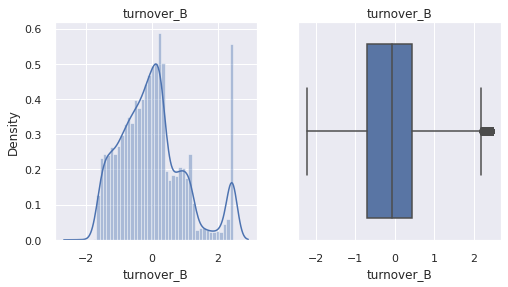

In [ ]:
distbox(8,df_prep)

Using metrics of skew and kurtosis, this feature is much improved.

#### lor_M



Skewness: -0.099043
Kurtosis: -1.132372
count    1.100800e+04
mean    -2.832440e-16
std      1.000045e+00
min     -1.284430e+00
25%     -1.284430e+00
50%      3.148325e-01
75%      3.148325e-01
max      2.730561e+00
Name: lor_M, dtype: float64
Nullcount: 0.000000


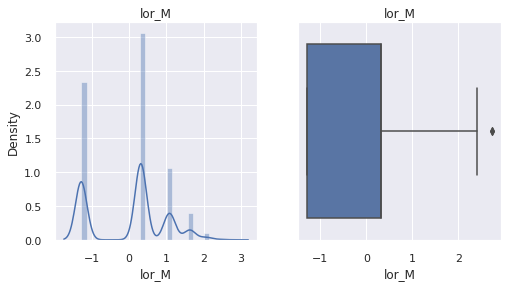

In [ ]:
distbox(9,df_prep)

We have reduced kurtosis and skew by normalizing and standardizing. We expect this to improve model performance, though if we have time we may attempt other transformations on this feature (or even use an untransformed feature) to see if the alternatives increase model performance.

#### city_2	

1    0.978289
0    0.021711
Name: city_2, dtype: float64
Nullcount: 0.000000


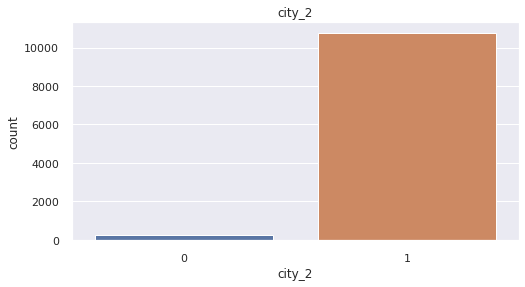

In [ ]:
distbox(10,df_prep,type= 'categorical')

Though the feature remains unbalanced, we expect the collapse of all other cities into a single value (an indicator column) to improve our model performance.

### Multivariate Review

### Quantitative Independence

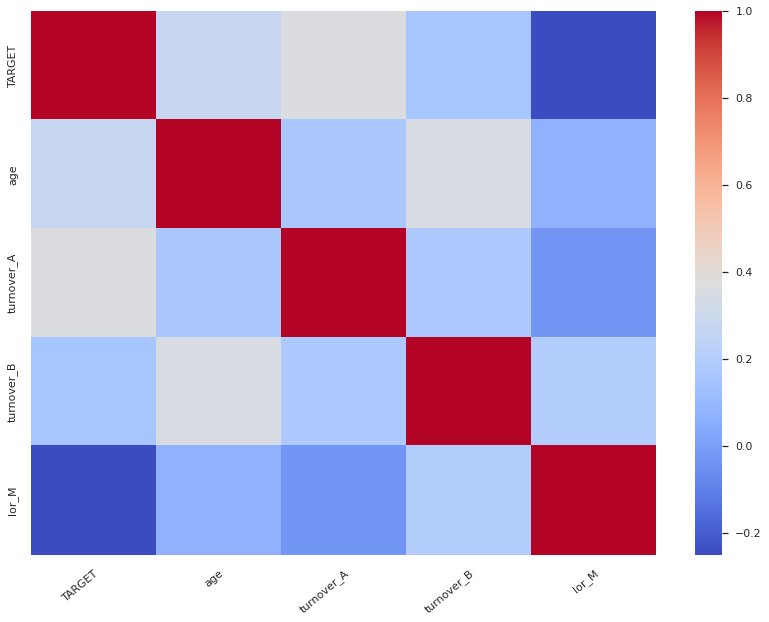

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(df_prep[['TARGET','age','turnover_A','turnover_B','lor_M']].corr(),cmap='coolwarm',annot=False);
plt.xticks(rotation=40 , rotation_mode='anchor',ha="right");

Our quantitative columns seem to be independent.

### Categorical Independence

For the categorical columns we will use chi<sup>2</sup> test for independence and a spearman r to get the  exact correlation

We will get the scores for each column pair and create a heat map to visualize our results. 

code referenced from:
[Analytics_vidhya](https://www.analyticsvidhya.com/blog/2021/06/decoding-the-chi-square-test%E2%80%8A-%E2%80%8Ause-along-with-implementation-and-visualization/)



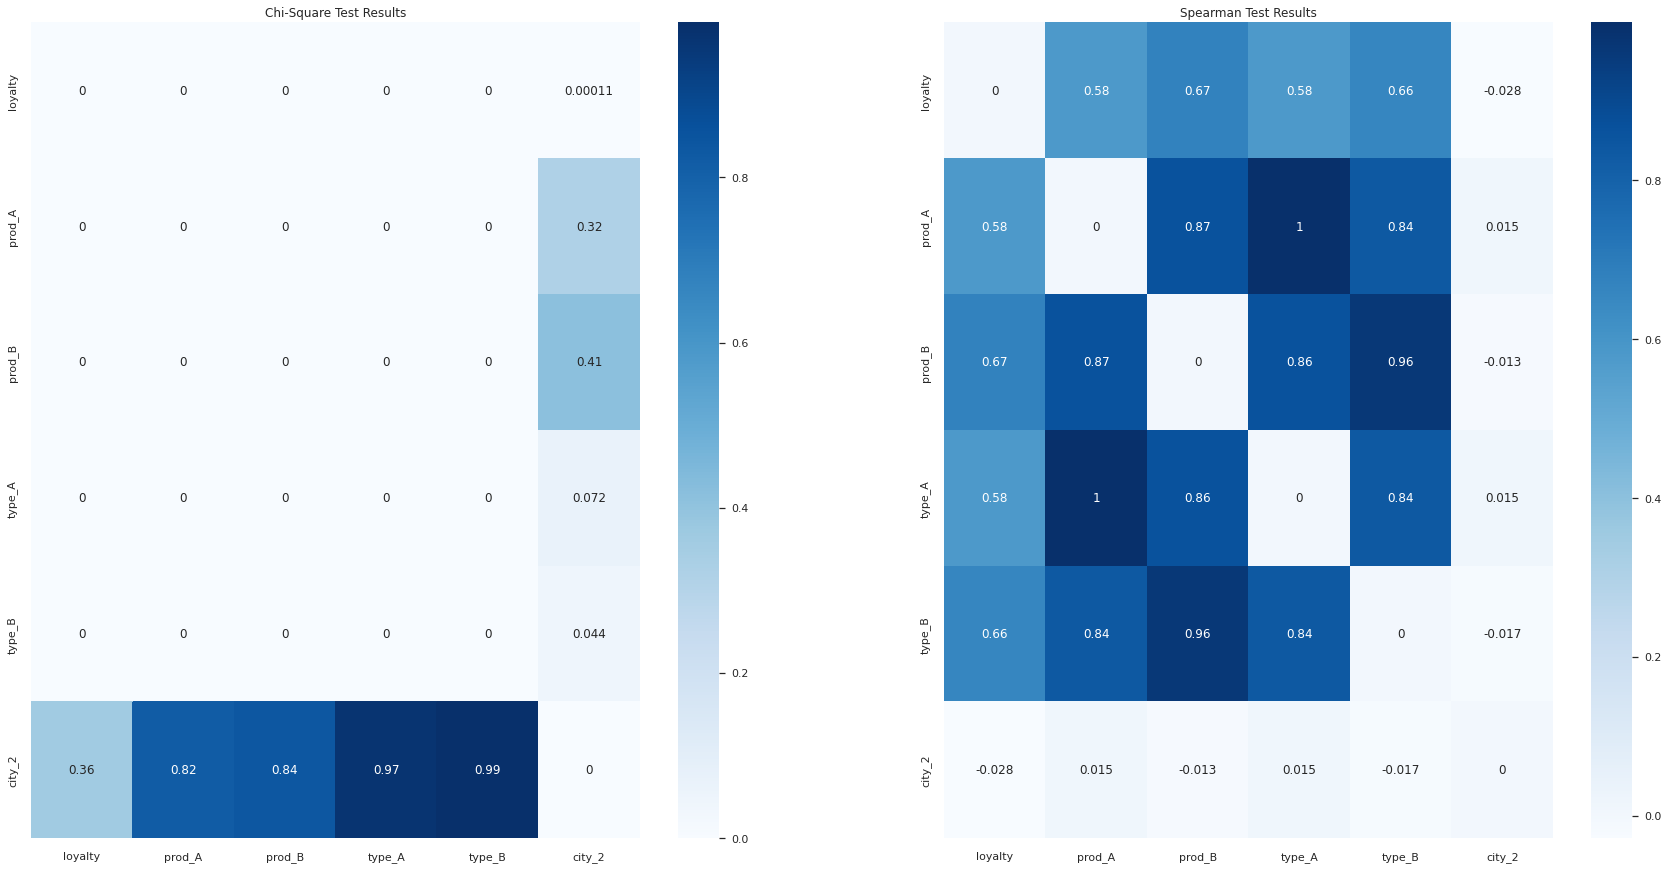

In [ ]:
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
cat_columns = ['loyalty', 'prod_A','prod_B', 'type_A', 'type_B', 'city_2']

chi_ps =[]
spearman = []
for cat in cat_columns:
  intermediate_P = []
  intermediat_spear = []
  for second_cat in cat_columns:
    if cat == second_cat:
      intermediate_P.append(0)
      intermediat_spear.append(0)
      continue
    chi = chi2(df_prep[cat].values.reshape(-1, 1),df_prep[second_cat].values.reshape(-1, 1))
    intermediate_P.append(chi[1][0])
    spear = spearmanr(df_prep[cat].values.reshape(-1, 1),df_prep[second_cat].values.reshape(-1, 1))
    intermediat_spear.append(spear[0])
  chi_ps.append(intermediate_P)
  spearman.append(intermediat_spear)


df_pvalues = pd.DataFrame(data= chi_ps,index=cat_columns,columns=cat_columns)
df_spearman = pd.DataFrame(data= spearman,index=cat_columns,columns=cat_columns)
#print(intermediat_spear)
#df_pvalues
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
sns.heatmap(df_pvalues, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.subplot(1,2,2)
sns.heatmap(df_spearman, annot=True, cmap='Blues')
plt.title('Spearman Test Results')
plt.show()


**conclusion**  
$\tilde{\chi}^2$ - our columns pairs mostly have a P-value of less than .05 from the test, except for city. We primarily accept the alternative hypothesis of the $\tilde{\chi}^2$ that these columns are not independent. 

Spearman r - confirms the results with two columns being 1 perfectly correlated. 

We will investigate our highest spearman r columns below to sanity check.

In [ ]:
#diving into a couple of examples
pd.crosstab(df['type_A'],df['prod_A'])

prod_A,0,1
type_A,,
0,6534,0
3,0,7452
6,0,30


In [ ]:
pd.crosstab(df['type_B'],df['prod_B'])

prod_B,0,1
type_B,,
0,5614,0
3,0,7874
6,0,493
9,0,35


This can see there isn't a lot of variance across these variables. They are not independent, which is not ideal for logistic regressions, though that is primarily for explainability. We will use only prod_A and prod_B, and not both in our initial feature selection to reduce dependent features.
##### drop non-independent columns

In [ ]:
df_extras = df_prep[['type_A','type_B']] # saving for recersive and fother feature selection techinques below
df_prep.drop(columns=['type_A','type_B'], inplace=True)
df_prep.head()#sanity check

,TARGET,loyalty,age,prod_A,prod_B,turnover_A,turnover_B,lor_M,city_2,loyal_uncat
0,1,0,1.884014,0,0,-0.706074,0.687482,-1.284430,1,1
1,1,2,0.963596,1,1,0.728694,1.039941,1.627726,1,0
2,1,2,0.780456,1,1,-0.445272,2.436374,1.084097,1,0
3,1,0,-0.096020,0,0,1.514769,0.145817,-1.284430,1,1
4,1,0,1.744273,0,0,0.546396,1.071100,-1.284430,1,1


# Regression Modeling 

We will now construct a number of binomial models using different feature sets. We will compare the results to see which is the best at predicting whether or not a customer will purchase an additional insurance product.

### Model 1

#### Feature Selection

Our first model will use the features we have prepared and selected so far in our df_prep dataframe.

In [ ]:
#as a reminder, we will review the df_prep dataframe
df_prep.head()

,TARGET,loyalty,age,prod_A,prod_B,turnover_A,turnover_B,lor_M,city_2,loyal_uncat
0,1,0,1.884014,0,0,-0.706074,0.687482,-1.284430,1,1
1,1,2,0.963596,1,1,0.728694,1.039941,1.627726,1,0
2,1,2,0.780456,1,1,-0.445272,2.436374,1.084097,1,0
3,1,0,-0.096020,0,0,1.514769,0.145817,-1.284430,1,1
4,1,0,1.744273,0,0,0.546396,1.071100,-1.284430,1,1


#### Split Train Test

In [ ]:
# Separate features and response variables. 
X = df_prep.drop(['TARGET'], axis = 1).values# assign the explanatory variables to a Python object
y = df_prep.TARGET.values# assign the response variable to a Python object

# split the data into training + testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify= X[:,[0,7]]#keep the sparse classes balanced in the training set
                                                    )


In [ ]:
#sanity checking the stratify
print('orginal data:')
print(df_prep.iloc[:,1].value_counts(normalize=True)) 
print("split data:")
pd.Series(data=X_train[:,0]).value_counts(normalize=True) 

orginal data:
0    0.458576
4    0.245367
2    0.183412
3    0.107558
1    0.005087
Name: loyalty, dtype: float64
split data:


0.0    0.458551
4.0    0.245401
2.0    0.183398
3.0    0.107540
1.0    0.005110
dtype: float64

Data has been properly stratified

#### Model Building 

following https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [ ]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.439349
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.251    
Dependent Variable: y                AIC:              9690.6982
Date:               2021-10-31 22:03 BIC:              9756.4556
No. Observations:   11008            Log-Likelihood:   -4836.3  
Df Model:           8                LL-Null:          -6455.9  
Df Residuals:       10999            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
x1      -0.0130     0.0395    -0.3287   0.7424   -0.0903    0.0644
x2       0.5491     0.0281    19.5291   0.0000    0.4940    0.6042
x3 

x9 and x3 ie age and loyal_uncat do not provide p values less than 0.05 however, after testing the model still performs better with them included. We will not adjust the features in this model.

In [ ]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

#### Model Evaluation

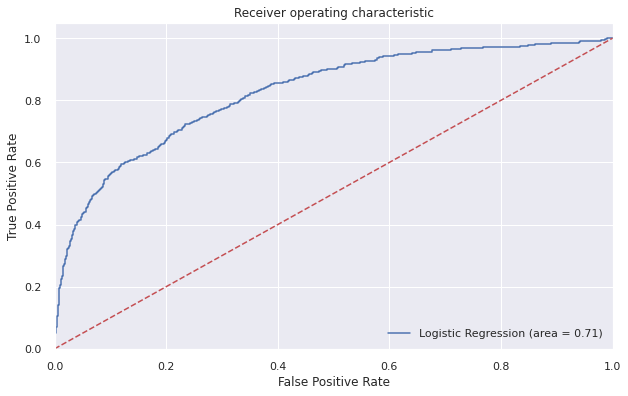

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This chart visualizes the tradeoff between true positive rate (TPR) and false
positive rate (FPR). It should hug the top left corner of the graph, and the area metric gives us an easy way to compare it.

We use it when we care equally about positive and negative classes, which is not our primary concern here. With a ROC AUC score of .71 it does better than random, but nothing too exciting.



In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.817
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1629
           1       0.71      0.49      0.58       573

    accuracy                           0.82      2202
   macro avg       0.78      0.71      0.73      2202
weighted avg       0.81      0.82      0.80      2202



This model has an f1 score of .58 for the 1 value in our response variable. The closer this metric is to 1A the better it predicts the positive class. We think we can do better. 

It has an accuracy of 81.7% which is relatively good. We will now run other models to compare these results.

### Model 2
For our second model we will utilize the additional features type_A and type_B, which we will dummy, and use recursive feature elimination to select the final feature set.


#### Feature Selection


In [ ]:
#selecting features and creating dummies

formula = """  TARGET ~ loyalty + age + prod_A + prod_B + C(type_A,Treatment(0)) + C(type_B,Treatment(0)) + turnover_A + turnover_B +  lor_M +  city_2 + loyal_uncat """
#adding df_extra back and creating ouput 
Y, X = dmatrices(formula,data= df_prep.join(df_extras), return_type='dataframe')

# we will drop the intercept because we forced our 0 values from type_A and Type_B into is and because we know those values are redundant to prod_A prod_B
X.drop(columns='Intercept', inplace=True)
X.head()

,"C(type_A, Treatment(0))[T.3]","C(type_A, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.3]","C(type_B, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.9]",loyalty,age,prod_A,prod_B,turnover_A,turnover_B,lor_M,city_2,loyal_uncat
0,0.0,0.0,0.0,0.0,0.0,0.0,1.884014,0.0,0.0,-0.706074,0.687482,-1.284430,1.0,1.0
1,1.0,0.0,1.0,0.0,0.0,2.0,0.963596,1.0,1.0,0.728694,1.039941,1.627726,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,2.0,0.780456,1.0,1.0,-0.445272,2.436374,1.084097,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.096020,0.0,0.0,1.514769,0.145817,-1.284430,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.744273,0.0,0.0,0.546396,1.071100,-1.284430,1.0,1.0


#### Split Train Test

We will stratify the data using the following columns for consistency during the split;
 * loyalty
 * city_2

In [ ]:
sparse_columns = ['loyalty','city_2']
X_train, X_test, y_train, y_test = train_test_split(X, Y.values, test_size=0.2, random_state=42,
                                                    stratify = X[sparse_columns]#stratifying to account for sparce classes
                                                    )

#### Model Building

We will use a recursive feature elimination model along the logistic regression for this dataset

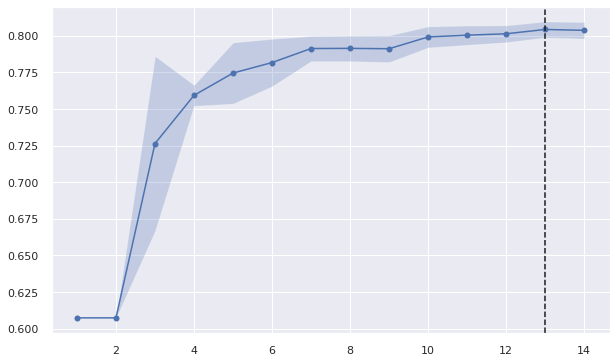

In [ ]:
model = LogisticRegression(max_iter=10000)
visualizer = RFECV(model,
                   scoring='f1_weighted', 
                   cv=5,
                   )
visualizer.fit(X_train,np.ravel(y_train));

In [ ]:
# what columns were dropped by RFE
X.columns[~visualizer.support_]

Index(['loyalty'], dtype='object')

#### Model Evaluation

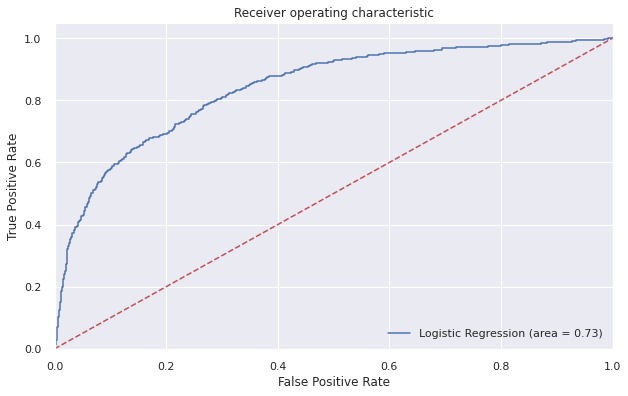

In [ ]:
#ROC curve
logit_roc_auc = roc_auc_score(y_test, visualizer.predict(X_test.values))
fpr, tpr, thresholds = roc_curve(y_test, visualizer.predict_proba(X_test.values)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

The ROC appears comparable to the model 1 ROC, though we see from the AUC metric that it improves from .71 to .73.

In [ ]:
y_pred = visualizer.predict(X_test.values)

print(f'Model accuracy = {visualizer.score(X_test.values, y_test)}\n')
print(classification_report(y_test, y_pred))

Model accuracy = 0.8206176203451407

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      1629
         1.0       0.71      0.53      0.61       573

    accuracy                           0.82      2202
   macro avg       0.78      0.73      0.74      2202
weighted avg       0.81      0.82      0.81      2202



The f1 score to identify customers who will purchase additional insurance products increases by 3 percent.

The 2nd model's accuracy has increased from ~%81.7 to ~%82.1.

In all respects. this is an improvement over our manually chosen feature set.

## Model 3

For the third model we will use the original dataset to compare our transformed data models to the original. We will use a random forest classifier to select the features.

#### Feature Prep

In [ ]:
#first a quick refresher on the original dataset
df.head(2)

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,1,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,1,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39


In [ ]:
#selecting features creating dummies
formula = """  TARGET ~ loyalty + age + city + LOR + prod_A + prod_B + C(type_A,Treatment(0)) + C(type_B,Treatment(0)) + turnover_A + turnover_B +  lor_M +  contract + age_P """

Y , X = dmatrices(formula,data= df, return_type='dataframe')

# we will drop the intercept because we forced our 0 values from type_A and Type_B into is and because we know those values are redundant to prod_A prod_B
X.drop(columns='Intercept', inplace=True)
X.head()

,"C(type_A, Treatment(0))[T.3]","C(type_A, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.3]","C(type_B, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.9]",loyalty,age,city,LOR,prod_A,prod_B,turnover_A,turnover_B,lor_M,contract,age_P
0,0.0,0.0,0.0,0.0,0.0,99.0,66.0,2.0,0.0,0.0,0.0,333.561114,264.721010,3.0,2.0,66.0
1,1.0,0.0,1.0,0.0,0.0,1.0,45.0,2.0,3.0,1.0,1.0,394.735699,284.904978,39.0,2.0,45.0
2,1.0,0.0,0.0,1.0,0.0,1.0,42.0,2.0,2.0,1.0,1.0,342.180990,1175.589721,27.0,2.0,42.0
3,0.0,0.0,0.0,0.0,0.0,99.0,31.0,2.0,0.0,0.0,0.0,453.757916,242.341754,3.0,2.0,31.0
4,0.0,0.0,0.0,0.0,0.0,99.0,62.0,2.0,0.0,0.0,0.0,384.577469,287.008370,3.0,2.0,62.0


#### Split Train Test


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, Y.values, test_size=0.2, random_state=42)

#### Feature Selection

reference [link](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f)

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, np.ravel(y_train))

features_columns = X.columns[sel.get_support()]

In [ ]:
sel.get_support()

array([False, False, False, False, False, False,  True, False, False,
       False, False,  True,  True, False, False,  True])

Index(['age', 'turnover_A', 'turnover_B', 'age_P'], dtype='object')


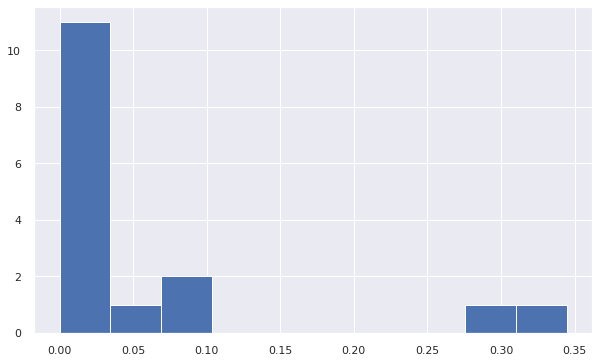

In [ ]:
print(features_columns)
pd.Series(sel.estimator_.feature_importances_.ravel()).hist();

**conclusion** 

Our features are not independent, so their importance is very hard for the random forest model to pick up.

#### Model Building

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train[features_columns],np.ravel(y_train))

LogisticRegression(max_iter=10000)

#### model evaluation

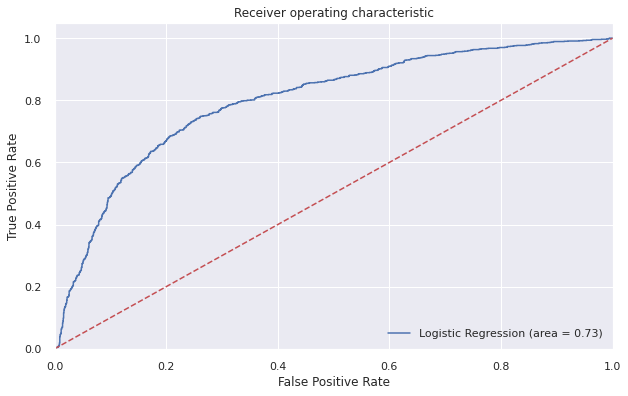

In [ ]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test[features_columns]))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test[features_columns])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

Our ROC AUC score remains unchanged.

In [ ]:
y_pred = model.predict(X_test[features_columns])

print(f'Model accuracy = {model.score(X_test[features_columns], y_test)} \n')
print(classification_report(y_test, y_pred))

Model accuracy = 0.7435805991440799 

              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79      1607
         1.0       0.73      0.63      0.68      1197

    accuracy                           0.74      2804
   macro avg       0.74      0.73      0.73      2804
weighted avg       0.74      0.74      0.74      2804



Our f1 score increased by another 5 percent using our original dataset and a random forest classifier. This is our best model yet!

Our accuracy decreased though. Perhaps this is an indication that our TARGET is not balanced?

## Models 4 & 5

For these models, we will once again start with our original dataset, this time utilizing forward selection via sklearn and MLextend Sequential Feature Selectors.

We will standardize our numeric features from within patsy and replace `city` with our indicator column developed in data_prep

We will train two versions of this model 
4. sklearns implementation of forward selection
5. with mlextends implementation

#### Feature Prep
steps:
  * replace city with city_2 from data_prep
  * dummy 
    * type_A
    * type_B
  * standardize
    * age
    * turnover_A
    * turnover_B
    * LOR_M <- this we will not center as having a negative relationship length isn't interpretable.




In [ ]:
#selecting features creating dummies
formula = """  TARGET ~ loyalty + standardize(age) + city + LOR + prod_A + prod_B + C(type_A,Treatment(0)) + C(type_B,Treatment(0)) + standardize(turnover_A) + standardize(turnover_B) +  standardize(lor_M ,center=False) + age_P """

# replacing city_2 with city 
data = df.copy()
data['city'] = df_prep.city_2

Y, X = dmatrices(formula,data= data, return_type='dataframe')

# we will drop the intercept because we forced our 0 values from type_A and Type_B into is and because we know those values are redundant to prod_A prod_B
X.drop(columns='Intercept', inplace=True)
X.head()

,"C(type_A, Treatment(0))[T.3]","C(type_A, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.3]","C(type_B, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.9]",loyalty,standardize(age),city,LOR,prod_A,prod_B,standardize(turnover_A),standardize(turnover_B),"standardize(lor_M, center=False)",age_P
0,0.0,0.0,0.0,0.0,0.0,99.0,2.321311,1.0,0.0,0.0,0.0,-0.492395,-0.134372,0.259020,66.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.702710,1.0,3.0,1.0,1.0,0.168174,-0.091933,3.367254,45.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.471481,1.0,2.0,1.0,1.0,-0.399317,1.780829,2.331176,42.0
3,0.0,0.0,0.0,0.0,0.0,99.0,-0.376357,1.0,0.0,0.0,0.0,0.805501,-0.181427,0.259020,31.0
4,0.0,0.0,0.0,0.0,0.0,99.0,2.013006,1.0,0.0,0.0,0.0,0.058484,-0.087510,0.259020,62.0


#### Split Test Train

In [ ]:
sparse_columns = ['loyalty','city']
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(Y.values), test_size=0.2, random_state=42,
                                                    stratify = X[sparse_columns]#stratifying to account for sparce classes
                                                    )

In [ ]:
X_train.head()

,"C(type_A, Treatment(0))[T.3]","C(type_A, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.3]","C(type_B, Treatment(0))[T.6]","C(type_B, Treatment(0))[T.9]",loyalty,standardize(age),city,LOR,prod_A,prod_B,standardize(turnover_A),standardize(turnover_B),"standardize(lor_M, center=False)",age_P
9931,1.0,0.0,1.0,0.0,0.0,99.0,-0.992967,1.0,1.0,1.0,1.0,-0.357629,-0.176214,1.295098,23.0
2239,1.0,0.0,1.0,0.0,0.0,3.0,-0.915890,1.0,1.0,1.0,1.0,0.412672,-0.206634,1.295098,24.0
6701,1.0,0.0,1.0,0.0,0.0,3.0,-0.838814,1.0,1.0,1.0,1.0,-0.379620,-0.232514,1.295098,25.0
9202,0.0,0.0,1.0,0.0,0.0,3.0,0.471481,1.0,1.0,0.0,1.0,-0.201816,1.131046,1.295098,42.0
8583,1.0,0.0,1.0,0.0,0.0,3.0,-0.992967,1.0,1.0,1.0,1.0,-0.585736,-0.184812,1.295098,23.0


In [ ]:
y_train

array([0., 1., 0., ..., 0., 1., 0.])

### Model Building

#### Sklearn Sequential Feature Selector 

In [ ]:
# substantiate new model to use in feature selection
model = LogisticRegression(max_iter=10000)
# substantiate feature finder
sfs = SequentialFeatureSelector(model, n_jobs=-1)

# use fit method find columns
sfs.fit(X_train,y_train)
# create column mask to utlize 
sfs_columns = X.columns[sfs.get_support()]
# fit model with columns selected by SequentialFeatureSelector
model.fit(X_train[sfs_columns],y_train)

LogisticRegression(max_iter=10000)

In [ ]:
sfs.get_feature_names_out()

array(['C(type_A, Treatment(0))[T.3]', 'C(type_A, Treatment(0))[T.6]',
       'C(type_B, Treatment(0))[T.9]', 'city', 'LOR',
       'standardize(turnover_A)', 'standardize(lor_M, center=False)'],
      dtype=object)

#### mlxtend Sequential Feature Selector

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished
Features: 1/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.9s finished
Features: 2/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    1.1s finished
Features: 3/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.2s finished
Features: 4/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.6s finished
Features: 5/15[Parallel(n_jobs=-1)]: Using back

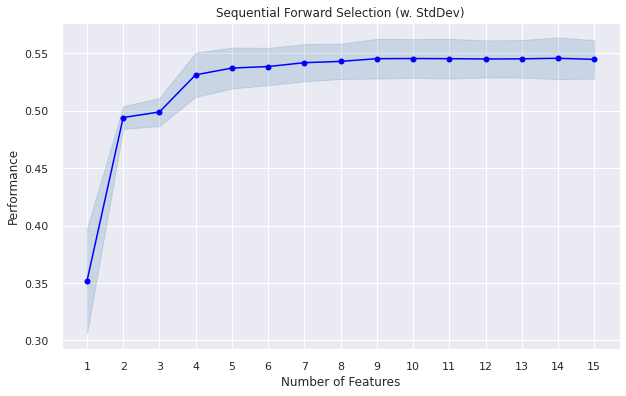

In [ ]:
model2 = LogisticRegression(max_iter=10000)
sfs2 = SFS(model2, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='f1',
          verbose=1,
          n_jobs=-1,
          cv=5)

sfs2 = sfs2.fit(X_train, y_train)

model2.fit(sfs2.transform(X_train),y_train)


plot = plot_sfs(sfs2.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.show()

In [ ]:
print('sklearn features {}  features selected:'.format(len(sfs.get_feature_names_out())))
print(sfs.get_feature_names_out(),'\n')
print('mlextend features:{} features selected:'.format(len(sfs2.k_feature_names_)))
print(sfs2.k_feature_names_)

sklearn features 7  features selected:
['C(type_A, Treatment(0))[T.3]' 'C(type_A, Treatment(0))[T.6]'
 'C(type_B, Treatment(0))[T.9]' 'city' 'LOR' 'standardize(turnover_A)'
 'standardize(lor_M, center=False)'] 

mlextend features:14 features selected:
('C(type_A, Treatment(0))[T.3]', 'C(type_B, Treatment(0))[T.3]', 'C(type_B, Treatment(0))[T.6]', 'C(type_B, Treatment(0))[T.9]', 'loyalty', 'standardize(age)', 'city', 'LOR', 'prod_A', 'prod_B', 'standardize(turnover_A)', 'standardize(turnover_B)', 'standardize(lor_M, center=False)', 'age_P')


### Model Evaluation

#### sklearn

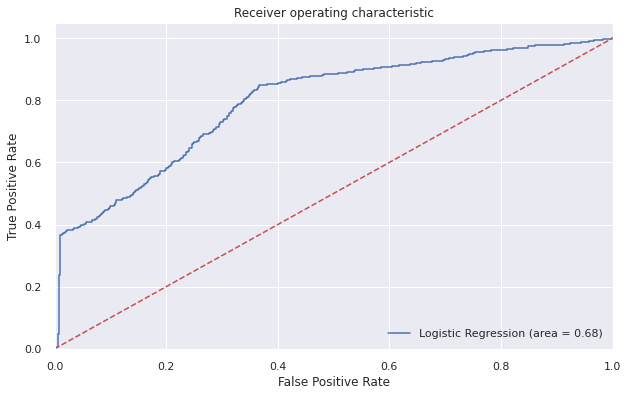

In [ ]:
# trasnforming X_test selected columns 
X1_test = X_test[sfs_columns]

logit_roc_auc = roc_auc_score(y_test, model.predict(X1_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X1_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

This is our worst ROC and lowest ROC AUC score yet. the original dataset did not fair well with sklearn's sfs model.

In [ ]:
y_pred = model.predict(X1_test)
print(f'Model accuracy = {model.score(X1_test, y_test)} \n')
print(classification_report(y_test, y_pred))

Model accuracy = 0.8265213442325159 

              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89      1644
         1.0       0.85      0.38      0.53       558

    accuracy                           0.83      2202
   macro avg       0.84      0.68      0.71      2202
weighted avg       0.83      0.83      0.80      2202



Though the accuracy is high, we do not care greatly for the correct identification of customers who will _not_ purchase more insurance. The f1 score for those who will is the lowest we've seen, and thus this is our worst model.

#### mlextend

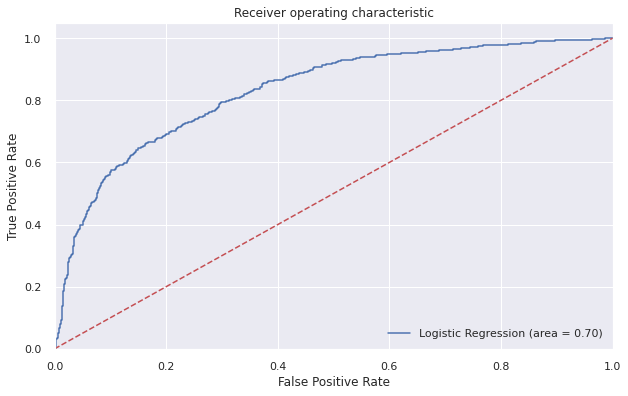

In [ ]:
# trasnforming X_test selected columns 
X2_test = sfs2.transform(X_test)

logit_roc_auc = roc_auc_score(y_test, model2.predict(X2_test))
fpr, tpr, thresholds = roc_curve(y_test, model2.predict_proba(X2_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

This chart and ROC AUC score improve on the sklearn implementation, but still don't match our first 3 models.

In [ ]:
y_pred = model2.predict(X2_test)
print(f'Model accuracy = {model2.score(X2_test, y_test)} \n')
print(classification_report(y_test, y_pred))

Model accuracy = 0.815622161671208 

              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88      1644
         1.0       0.70      0.47      0.56       558

    accuracy                           0.82      2202
   macro avg       0.77      0.70      0.72      2202
weighted avg       0.80      0.82      0.80      2202



The f1 score and accuracy are not the highest we have seen.

#  Conclusion


**model summary** 

| Model  |AUC | F1  | Accuracy |
|:-:|:-:|:-:|:--:|
| Model 1  | .71  | .58  | .817 |   
| Model 2  | .73  | .61  | .821 |  
| Model 3  | .73  | .68  | .744 | 
| Model 4  | .68  | .53  | .827 |
| Model 5  | .7   | .56  | .816 |




F1 combines precision and recall into one metric. It is used when we care more about the positive class. That is our current case, and thus our most important metric.

Accuracy and ROC AUC are important when we care about the prediction of both classes. We calculate accuracy on the predicted classes while you calculate ROC AUC on predicted scores. We, therefore, care more about accuracy than ROC AUC (we also don't care about ranking the predictions here).*

We conclude that Model 3 based on the original dataset and a random forest classifier is our preferred model. This is followed by Model 2 our df_prep dataframe which used a recursive feature elimination model.

**Potential next steps** include the following:
* try variations of these training models and features 
  * df with recursive feature elimination, 
  * df_prep with random forest classifiers 
  * etc. 
* work to further identify the optimal set of features and models out of all possible choices.
 * see if ordinal features do better under different treatments such as polynomial 
 * look for interaction effects between features to be included in our models.

*interpretations based on: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc